In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
class RBuffer():
    def __init__(self, maxsize, statedim, naction):
        self.cnt = 0
        self.maxsize = maxsize
        self.state_memory = np.zeros((maxsize, *statedim), dtype=np.float32)
        self.action_memory = np.zeros((maxsize, naction), dtype=np.float32)
        self.reward_memory = np.zeros((maxsize,), dtype=np.float32)
        self.next_state_memory = np.zeros((maxsize, *statedim), dtype=np.float32)
        self.done_memory = np.zeros((maxsize,), dtype= np.bool)

    def storexp(self, state, next_state, action, done, reward):
        index = self.cnt % self.maxsize
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.done_memory[index] = 1- int(done)
        self.cnt += 1

    def sample(self, batch_size):
        max_mem = min(self.cnt, self.maxsize)
        batch = np.random.choice(max_mem, batch_size, replace= False)
        states = self.state_memory[batch]
        next_states = self.next_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        dones = self.done_memory[batch]
        return states, next_states, rewards, actions, dones

In [3]:
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.f1 = tf.keras.layers.Dense(64, activation='relu')
        self.f2 = tf.keras.layers.Dense(64, activation='relu')
        self.f3 = tf.keras.layers.Dense(64, activation='relu')
        self.f4 = tf.keras.layers.Dense(64, activation='relu')
        self.v =  tf.keras.layers.Dense(1, activation=None)

    def call(self, inputstate, action):
        x = self.f1(tf.concat([inputstate, action], axis=1))
        x = self.f2(x)
        x = self.f3(x)
        x = self.f4(x)
        x = self.v(x)
        return x

In [4]:
class Actor(tf.keras.Model):
    def __init__(self, no_action):
        super(Actor, self).__init__()
        self.f1 = tf.keras.layers.Dense(64, bias_initializer='zeros', kernel_initializer='zeros', activation='relu')
        self.f2 = tf.keras.layers.Dense(64, bias_initializer='zeros', kernel_initializer='zeros', activation='relu')
        self.mu =  tf.keras.layers.Dense(no_action, activation=None)

    def call(self, state):
        x = self.f1(state)
        x = self.f2(x)
        x = self.mu(x)
        return x

In [5]:
class Agent():
    def __init__(self, n_action= 2):
        self.actor_main = Actor(n_action)
        self.actor_target = Actor(n_action)
        self.critic_main = Critic()
        self.critic_main2 = Critic()
        self.critic_target = Critic()
        self.critic_target2 = Critic()
        self.batch_size = 64
        self.n_actions = 2
        self.a_opt = tf.keras.optimizers.Adam(0.001)
        # self.actor_target = tf.keras.optimizers.Adam(.001)
        self.c_opt1 = tf.keras.optimizers.Adam(0.002)
        self.c_opt2 = tf.keras.optimizers.Adam(0.002)
        # self.critic_target = tf.keras.optimizers.Adam(.002)
        self.memory = RBuffer(100000, [3], n_action)
        self.trainstep = 0
        #self.replace = 5
        self.gamma = 0.99
        self.min_action = -100
        self.max_action = 100
        self.actor_update_steps = 20
        self.warmup = 200
        self.actor_target.compile(optimizer=self.a_opt)
        self.critic_target.compile(optimizer=self.c_opt1)
        self.critic_target2.compile(optimizer=self.c_opt2)
        self.tau = 0.005

    def savexp(self,state, next_state, action, done, reward):
        self.memory.storexp(state, next_state, action, done, reward)

    def update_target(self, tau=None):

        if tau is None:
            tau = self.tau

        weights1 = []
        targets1 = self.actor_target.weights
        for i, weight in enumerate(self.actor_main.weights):
            weights1.append(weight * tau + targets1[i]*(1-tau))
        self.actor_target.set_weights(weights1)

        weights2 = []
        targets2 = self.critic_target.weights
        for i, weight in enumerate(self.critic_main.weights):
            weights2.append(weight * tau + targets2[i]*(1-tau))
        self.critic_target.set_weights(weights2)


        weights3 = []
        targets3 = self.critic_target2.weights
        for i, weight in enumerate(self.critic_main2.weights):
            weights3.append(weight * tau + targets3[i]*(1-tau))
        self.critic_target2.set_weights(weights3)

  
    def train(self):
        if self.memory.cnt < self.batch_size:
            return

        states, next_states, rewards, actions, dones = self.memory.sample(self.batch_size)

        states = tf.convert_to_tensor(states, dtype= tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype= tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype= tf.float32)
        actions = tf.convert_to_tensor(actions, dtype= tf.float32)
        #dones = tf.convert_to_tensor(dones, dtype= tf.bool)

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:

            target_actions = self.actor_target(next_states)
            target_actions += tf.clip_by_value(tf.random.normal(shape=[*np.shape(target_actions)], mean=0.0, stddev=2), -0.5, 0.5)
            target_actions = tf.clip_by_value(target_actions, self.min_action, self.max_action)


            target_next_state_values = tf.squeeze(self.critic_target(next_states, target_actions), 1)
            target_next_state_values2 = tf.squeeze(self.critic_target2(next_states, target_actions), 1)

            critic_value = tf.squeeze(self.critic_main(states, actions), 1)
            critic_value2 = tf.squeeze(self.critic_main2(states, actions), 1)

            next_state_target_value = tf.math.minimum(target_next_state_values, target_next_state_values2)

            target_values = rewards + self.gamma * next_state_target_value * dones
            critic_loss1 = tf.keras.losses.MSE(target_values, critic_value)
            critic_loss2 = tf.keras.losses.MSE(target_values, critic_value2)

        grads1 = tape1.gradient(critic_loss1, self.critic_main.trainable_variables)
        grads2 = tape2.gradient(critic_loss2, self.critic_main2.trainable_variables)

        self.c_opt1.apply_gradients(zip(grads1, self.critic_main.trainable_variables))
        self.c_opt2.apply_gradients(zip(grads2, self.critic_main2.trainable_variables))


        self.trainstep +=1

        if self.trainstep % self.actor_update_steps == 0:

            with tf.GradientTape() as tape3:

                new_policy_actions = self.actor_main(states)
                actor_loss = self.critic_main(states, new_policy_actions)
                actor_loss = tf.math.reduce_mean(actor_loss)

            grads3 = tape3.gradient(actor_loss, self.actor_main.trainable_variables)
            self.a_opt.apply_gradients(zip(grads3, self.actor_main.trainable_variables))

        #if self.trainstep % self.replace == 0:
        self.update_target()

    def act(self, state, evaluate=False):
        if self.trainstep > self.warmup:
            evaluate = True
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor_main(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=1)
        actions = tf.clip_by_value(actions, self.min_action, self.max_action)
        return actions[0]

In [6]:
from Angrybird import AngryBird
with tf.device('GPU:0'):
    tf.random.set_seed(336699)
    agent = Agent(2)
    env = AngryBird()
    episods = 2000
    ep_reward = []
    total_avgr = []
    target = False

    for s in range(episods):
        if target == True:
            break
        total_reward = 0
        state = env.reset()
        done = False
        ## model of wing
        cost = 0

        while not done:
            action = agent.act(state)
            if (s+1) % 15 == 0 and False:
                #print(s, state[0])
                plt.scatter(state[1], state[2])
            next_state, reward, done, _ = env.step(action)
            agent.savexp(state, next_state, action, done, reward)
            agent.train()
            state = next_state
            total_reward += reward
        if done and s % 50 == 0:
            ep_reward.append(total_reward)
            avg_reward = np.mean(ep_reward[-100:])
            total_avgr.append(avg_reward)
            print("total reward after {} steps is {} and avg reward is {}".format(s, total_reward, avg_reward))
            if int(avg_reward) == 200:
                target = True

total reward after 0 steps is 668692.3826944717 and avg reward is 668692.3826944717
total reward after 50 steps is 12527250.419259246 and avg reward is 6597971.400976859
total reward after 100 steps is 21217291.89869372 and avg reward is 11471078.233549148
total reward after 150 steps is 112167.0263918016 and avg reward is 8631350.431759812
total reward after 200 steps is 208681285.41667163 and avg reward is 48641337.42874218
total reward after 250 steps is 2105451.9566195915 and avg reward is 40885356.51672175
total reward after 300 steps is 232434204.07623878 and avg reward is 68249477.59665275
total reward after 350 steps is 8250325.539083164 and avg reward is 60749583.58945654
total reward after 400 steps is 2516419.724086655 and avg reward is 54279232.04885989
total reward after 450 steps is 60.13213666804054 and avg reward is 48851314.85718756
total reward after 500 steps is 568430.5894486806 and avg reward is 44461961.741938576
total reward after 550 steps is 14740806.753388774 

In [7]:
agent.actor_main.save_weights("td3_actor")

In [8]:
a = Actor(2)
a.load_weights("td3_actor")

3.2364431230237187
3.2364431230237187
3.2364431230237187
3.2364431230237187
3.2364431230237187
3.2364431230237187
3.2364431230237187
3.2364431230237187
3.2364431230237187
14529098.84292482
14529127.970912928


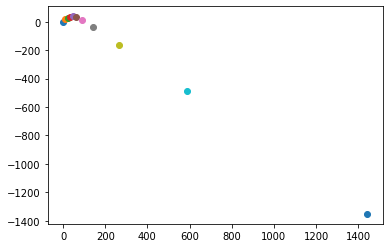

In [9]:
env = AngryBird()
with tf.device('GPU:0'):
    total_reward = 0
    state = env.reset()
    done = False
    ## model of wing
    cost = 0

    while not done:
        action = agent.act(state, evaluate=True)
        plt.scatter(state[1], state[2])
        next_state, reward, done, _ = env.step(action)
        print(reward)
        state = next_state
        cost += reward
    print(cost)
    plt.scatter(state[1], state[2])

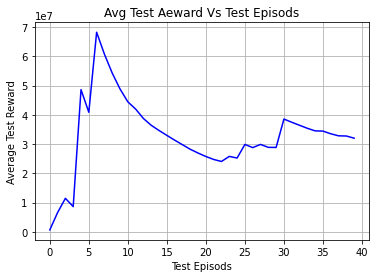

In [10]:
ep = [i  for i in range(len(total_avgr))]
plt.plot( range(len(total_avgr)),total_avgr,'b')
plt.title("Avg Test Aeward Vs Test Episods")
plt.xlabel("Test Episods")

plt.ylabel("Average Test Reward")
plt.grid(True)
plt.show()